Before starting, you will need to install some packages to reproduce the baseline.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# 4 min in colab
! unzip -q /content/drive/MyDrive/challenge_owkin/train_input.zip -d /content
! unzip -q /content/drive/MyDrive/challenge_owkin/test_input.zip -d /content
! unzip -q /content/drive/MyDrive/challenge_owkin/supplementary_data_fLolZIs.zip -d /content
! cp /content/drive/MyDrive/challenge_owkin/train_output.csv /content/train_output.csv

Mounted at /content/drive


In [3]:
%cd /content/supplementary_data/

/content/supplementary_data


In [ ]:
!pip install tqdm --quiet
!pip install scikit-learn 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

# Data architecture

## Data loading

In [5]:
# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path("../")

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train = pd.read_csv(data_dir  / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir  / "supplementary_data" / "test_metadata.csv")

# concatenate y_train and df_train
y_train = pd.read_csv(data_dir  / "train_output.csv")
df_train = df_train.merge(y_train, on="Sample ID")

print(f"Training data dimensions: {df_train.shape}")  # (344, 4)
df_train.head()

Training data dimensions: (344, 4)


,Sample ID,Patient ID,Center ID,Target
0,ID_001.npy,P_001,C_1,0
1,ID_002.npy,P_002,C_2,1
2,ID_005.npy,P_005,C_5,0
3,ID_006.npy,P_006,C_5,0
4,ID_007.npy,P_007,C_2,1


## Data processing

We now load the features matrices $\mathbf{K_s} \in \mathbb{R}^{(1000,\,2048)}$ for $s=1,...,344$ and perform slide-level averaging. This operation should take at most 5 minutes on your laptop.

In [754]:
X_train = []
y_train = []
centers_train = []
patients_train = []

for sample, label, center, patient in tqdm(
    df_train[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
    # slide-level averaging
    X_train.append(np.mean(features, axis=0))
    y_train.append(label)
    centers_train.append(center)
    patients_train.append(patient)

# convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
centers_train = np.array(centers_train)
patients_train = np.array(patients_train)

100%|██████████| 344/344 [00:12<00:00, 27.72it/s]


In [755]:
X_test = []
centers_test = []
patients_test = []

# load the data from `df_test` (~ 1 minute)
for sample, center, patient in tqdm(
    df_test[["Sample ID", "Center ID", "Patient ID"]].values
):
    _features = np.load(test_features_dir / sample)
    coordinates, features = _features[:, :3], _features[:, 3:]
    X_test.append(np.mean(features, axis=0))
    centers_test.append(center)
    patients_test.append(patient)

X_test = np.array(X_test)

100%|██████████| 149/149 [00:00<00:00, 226.57it/s]


## Where do patients come from ? Do sample embeddings depend on the hospital ?

In [818]:
X = np.concatenate([X_train, X_test])

centers = np.concatenate([centers_train, centers_test])
unique_values, indices = np.unique(centers, return_inverse=True)

print('Train centers:', np.unique(centers_train))
print('Test centers:', np.unique(centers_test))

Train centers: ['C_1' 'C_2' 'C_5']
Test centers: ['C_3' 'C_4']


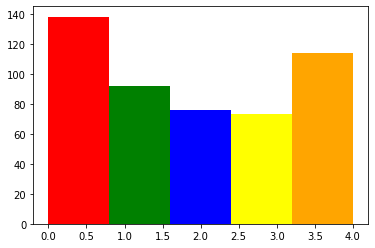

In [819]:
n, bins, patches = plt.hist(indices, bins=5)
colors = ['red', 'green', 'blue', 'yellow', 'orange']
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', colors[i])
plt.show()

In [820]:
from sklearn.manifold import TSNE

print('X_train shape:', X.shape)

tsne = TSNE(n_components=2, 
            learning_rate='auto', 
            init='random', 
            perplexity=3)

X_embedded = tsne.fit_transform(X)

print('After embedding:', X_embedded.shape)

X_train shape: (493, 2048)
After embedding: (493, 2)


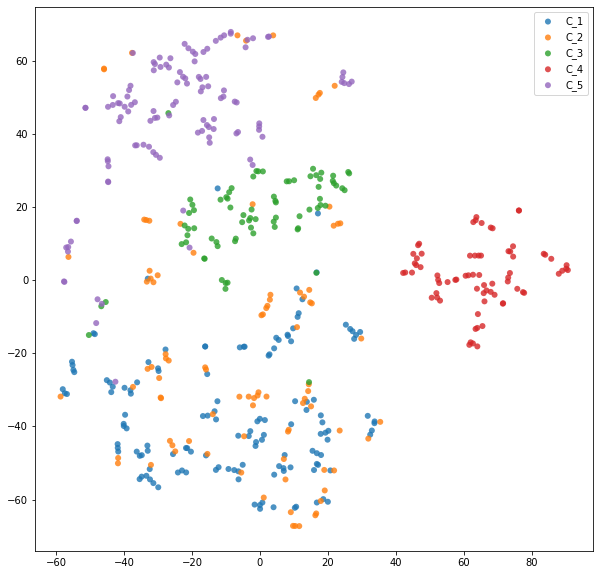

In [821]:
fig, ax = plt.subplots(figsize=(10, 10))
for i, center in enumerate(unique_values):
    x = X_embedded[indices==i]
    ax.scatter(x[:, 0], x[:, 1], label=center, alpha=0.8, edgecolors='none')
plt.legend()

## Attention Pytorch https://github.com/AMLab-Amsterdam/AttentionDeepMIL/

### Utils

In [715]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.L = 2048 # num features
        self.D = 8 # hidden dim
        self.K = 1 # dim attention coeff

        # 1st conv classifier part
        # # images are (N, 28, 28) 
        # self.feature_extractor_part1 = nn.Sequential(
        #     nn.Conv2d(1, 20, kernel_size=5),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, stride=2),
        #     nn.Conv2d(20, 50, kernel_size=5),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, stride=2)
        # )
        # # => 24/12/8/4 => (N, 4, 4, 50)

        # split classifier into two parts reshape
        # (N, 4, 4, 50) => (N, 1, 4*4*50) = (N, 800)

        # 2nd dense classifier part
        # self.feature_extractor_part2 = nn.Sequential(
        #     nn.Linear(50 * 4 * 4, self.L),
        #     nn.ReLU(),
        # )
        # output is (None, L)

        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Sequential(
            # nn.Linear(self.L*self.K, 16),
            # nn.SELU(),
            nn.Linear(self.L, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # we always give one batch (bs=1), of shape (1, N, 2048)
        # squeeze to (N, 2048) => 1000 1-d vectors => can apply Linear layers
        x = x.squeeze(0)

        # H = self.feature_extractor_part1(x)
        # H = H.view(-1, 50 * 4 * 4) # Pytorch's reshape function, reshape to 2D, N x 800
        # H = self.feature_extractor_part2(H)  # N x L, L is the embedding dim of the images after feature extraction

        A = self.attention(x)  # NxK
        A = torch.transpose(A, 1, 0)  # KxN
        A = F.softmax(A, dim=-1)  # softmax over N

        M = torch.mm(A, x)  # KxL

        Y_prob = self.classifier(M)
        Y_hat = torch.ge(Y_prob, 0.5).float()

        return Y_prob, Y_hat



class GatedAttention(nn.Module):
    def __init__(self):
        super(GatedAttention, self).__init__()
        self.L = 2048 # num features
        self.D = 1 # hidden dim
        self.K = 1 # dim attention coeff

        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        self.attention_V = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh()
        )

        self.attention_U = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Sigmoid()
        )

        self.attention_weights = nn.Linear(self.D, self.K)

        self.classifier = nn.Sequential(
            nn.Linear(self.L*self.K, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # we receive a batch of shape (B, N, 2048)
        A_V = self.attention_V(x)  # BxNxD
        A_U = self.attention_U(x)  # BxNxD
        A = self.attention_weights(A_V * A_U) # element wise multiplication # BxNxK
        A = torch.transpose(A, 1, 2)  # BxKxN
        A = F.softmax(A, dim=-1)  # softmax over N - BxKxN
        M = torch.matmul(A, x)  # BxKxL

        Y_prob = self.classifier(M).squeeze() # shape of B
        Y_hat = torch.ge(Y_prob, 0.5).float() # shape of B

        return Y_prob, Y_hat

### Training

In [716]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, df, features_dir, instances_per_bag=1.0, test = False):
        self.df = df
        self.features_dir = features_dir
        self.test = test
        self.instances_per_bag = instances_per_bag

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if self.test:
            sample = self.df.iloc[idx]["Sample ID"]
        else:
            sample, label = self.df.iloc[idx][["Sample ID", "Target"]]
            
        # load the coordinates and features (1000, 3+2048)
        _features = np.load(self.features_dir / sample)
        # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
        # and the MoCo V2 features
        coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
        
        # Subsampling - data augmentation, only take a part of the patches of the bag
        idx = np.arange(len(features)) # [0, num_samples]
        idx = np.random.choice(idx, size=self.instances_per_bag, replace=False) # random choice in this intervall
        features = features[idx]

        return {'x':features, 'y':label}

In [717]:
from torch.utils.data import DataLoader

N_split = 250 # [0, 344]
BATCH_SIZE = 34
INSTANCES_PER_BAG = 25

# create datasets
train_dataset = MyDataset(
    df=df_train.iloc[:N_split], 
    instances_per_bag=INSTANCES_PER_BAG, 
    features_dir=train_features_dir
    )
val_dataset = MyDataset(
    df=df_train.iloc[N_split:],
    instances_per_bag=INSTANCES_PER_BAG, 
    features_dir=train_features_dir,
    )

# create data loaders
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    )
val_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False,
    )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [718]:
from torch.nn import BCELoss
from torch.optim import Adam

# model = Attention().to(device)
model = GatedAttention().to(device)
criterion = BCELoss().to(device)
optimizer = Adam(
    model.parameters(), 
    lr=1e-3,
    # weight_decay=1e-3,
    )

print(model)

GatedAttention(
  (attention): Sequential(
    (0): Linear(in_features=2048, out_features=1, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1, out_features=1, bias=True)
  )
  (attention_V): Sequential(
    (0): Linear(in_features=2048, out_features=1, bias=True)
    (1): Tanh()
  )
  (attention_U): Sequential(
    (0): Linear(in_features=2048, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (attention_weights): Linear(in_features=1, out_features=1, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [719]:
# try to send a batch through the model
for batch in train_loader:
  print(model(batch['x']))
  break

(tensor([0.5065, 0.5096, 0.5075, 0.5059, 0.4986, 0.4974, 0.5052, 0.5127, 0.4992,
        0.5087, 0.4891, 0.4894, 0.4953, 0.5018, 0.4978, 0.4961, 0.4849, 0.5136,
        0.4905, 0.5144, 0.4972, 0.4965, 0.5004, 0.4942, 0.5049, 0.4941, 0.5005,
        0.5030, 0.5149, 0.4977, 0.5092, 0.5010, 0.4897, 0.5044],
       grad_fn=<SqueezeBackward0>), tensor([1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1.]))


In [720]:
NUM_EPOCHS = 100

# Initialize lists to store loss and metrics values
train_losses = []
val_losses = []
train_roc_aucs = []
val_roc_aucs = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, NUM_EPOCHS+1):

    print(f'Epoch - {epoch}/{NUM_EPOCHS}')

    # Set the model to train mode
    model.train()
    train_loss = 0
    train_accuracy = 0
    train_outputs = []
    train_labels = []

    for i, batch in tqdm(enumerate(train_loader)):
        # Extract data and labels from batch
        X_batch = batch['x']
        y_batch = batch['y'] 

        # Forward pass
        output, pred01 = model(X_batch) # 2 * shape [B]

        # Store pred and label for ROC AUC Score
        train_outputs += list(output.detach().numpy())
        train_labels += list(y_batch.detach().numpy())

        # Compute loss over batch = for one patient
        loss = criterion(output, y_batch.to(torch.float32)) # label are int, need tf float to match preds
        train_loss = i / (i+1) * train_loss + 1 / (i+1) * loss.item()
        
        # Update train accuracy
        batch_acc = torch.sum(pred01 == y_batch) / len(pred01)
        train_accuracy = i / (i+1) * train_accuracy + 1 / (i+1) * batch_acc

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    

    # Compute the train_roc_auc
    train_roc_auc = roc_auc_score(train_labels, train_outputs)

    # Save loss and metrics in lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_roc_aucs.append(train_roc_auc)

# ==============================================================================

    # Set the model to evaluation mode - switch layers to eval mode (ex. dropout)
    model.eval()
    val_loss = 0
    val_roc_auc = 0
    val_accuracy = 0
    val_labels = []
    val_outputs = []

    # Turn off gradient computation
    with torch.no_grad():

        # Iterate over the validation data
        for i, batch in tqdm(enumerate(val_loader)):
            # Extract data and labels from batch
            X_batch = batch['x']
            y_batch = batch['y'] 

            # Forward pass
            output, pred01 = model(X_batch) # 2 * shape [B]

            # Store pred and label for ROC AUC Score
            val_outputs += list(output.detach().numpy())
            val_labels += list(y_batch.detach().numpy())

            # Compute loss over batch = for one patient
            loss = criterion(output, y_batch.to(torch.float32)) # label are int, need tf float to match preds
            val_loss = i / (i+1) * val_loss + 1 / (i+1) * loss.item()
            
            # Update val accuracy
            batch_acc = torch.sum(pred01 == y_batch) / len(pred01)
            val_accuracy = i / (i+1) * val_accuracy + 1 / (i+1) * batch_acc
          
    # Compute val_roc_auc
    val_roc_auc = roc_auc_score(val_labels, val_outputs)

    # Save loss and metrics in lists
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_roc_aucs.append(val_roc_auc)

    print(f'Epoch {epoch} - loss: {train_loss:.5f} - acc: {train_accuracy:.5f} - roc_auc: {train_roc_auc:.3f} - val_loss: {val_loss:.5f} - val_acc: {val_accuracy:.5f} - roc_auc: {val_roc_auc:.3f} ')

Epoch - 1/100


8it [00:01,  7.18it/s]
3it [00:00,  7.10it/s]


Epoch 1 - loss: 0.66885 - acc: 0.62684 - roc_auc: 0.505 - val_loss: 0.66758 - val_acc: 0.61689 - roc_auc: 0.458 
Epoch - 2/100


8it [00:01,  7.98it/s]
3it [00:00,  7.87it/s]


Epoch 2 - loss: 0.64114 - acc: 0.64828 - roc_auc: 0.607 - val_loss: 0.66880 - val_acc: 0.61689 - roc_auc: 0.499 
Epoch - 3/100


8it [00:00,  8.05it/s]
3it [00:00,  8.46it/s]


Epoch 3 - loss: 0.65098 - acc: 0.62806 - roc_auc: 0.699 - val_loss: 0.66674 - val_acc: 0.61689 - roc_auc: 0.555 
Epoch - 4/100


8it [00:00,  8.05it/s]
3it [00:00,  8.64it/s]


Epoch 4 - loss: 0.63905 - acc: 0.63480 - roc_auc: 0.737 - val_loss: 0.66269 - val_acc: 0.61689 - roc_auc: 0.585 
Epoch - 5/100


8it [00:01,  7.93it/s]
3it [00:00,  8.77it/s]


Epoch 5 - loss: 0.63931 - acc: 0.61458 - roc_auc: 0.769 - val_loss: 0.65756 - val_acc: 0.61689 - roc_auc: 0.606 
Epoch - 6/100


8it [00:00,  8.15it/s]
3it [00:00,  7.82it/s]


Epoch 6 - loss: 0.62390 - acc: 0.63480 - roc_auc: 0.766 - val_loss: 0.65386 - val_acc: 0.60709 - roc_auc: 0.637 
Epoch - 7/100


8it [00:00,  8.30it/s]
3it [00:00,  8.33it/s]


Epoch 7 - loss: 0.61375 - acc: 0.64522 - roc_auc: 0.760 - val_loss: 0.65384 - val_acc: 0.61689 - roc_auc: 0.602 
Epoch - 8/100


8it [00:00,  8.03it/s]
3it [00:00,  8.53it/s]


Epoch 8 - loss: 0.60689 - acc: 0.64828 - roc_auc: 0.758 - val_loss: 0.65708 - val_acc: 0.60709 - roc_auc: 0.600 
Epoch - 9/100


8it [00:01,  7.87it/s]
3it [00:00,  7.86it/s]


Epoch 9 - loss: 0.62705 - acc: 0.62132 - roc_auc: 0.739 - val_loss: 0.64629 - val_acc: 0.61689 - roc_auc: 0.662 
Epoch - 10/100


8it [00:00,  8.25it/s]
3it [00:00,  8.85it/s]


Epoch 10 - loss: 0.60183 - acc: 0.63542 - roc_auc: 0.760 - val_loss: 0.64318 - val_acc: 0.61011 - roc_auc: 0.646 
Epoch - 11/100


8it [00:00,  8.14it/s]
3it [00:00,  8.16it/s]


Epoch 11 - loss: 0.59552 - acc: 0.69608 - roc_auc: 0.774 - val_loss: 0.64300 - val_acc: 0.61011 - roc_auc: 0.654 
Epoch - 12/100


8it [00:00,  8.17it/s]
3it [00:00,  8.20it/s]


Epoch 12 - loss: 0.59303 - acc: 0.66115 - roc_auc: 0.777 - val_loss: 0.64134 - val_acc: 0.61991 - roc_auc: 0.643 
Epoch - 13/100


8it [00:00,  8.17it/s]
3it [00:00,  8.48it/s]


Epoch 13 - loss: 0.57474 - acc: 0.70650 - roc_auc: 0.792 - val_loss: 0.63845 - val_acc: 0.61991 - roc_auc: 0.664 
Epoch - 14/100


8it [00:01,  7.87it/s]
3it [00:00,  8.18it/s]


Epoch 14 - loss: 0.59323 - acc: 0.65074 - roc_auc: 0.782 - val_loss: 0.63781 - val_acc: 0.60709 - roc_auc: 0.665 
Epoch - 15/100


8it [00:00,  8.16it/s]
3it [00:00,  8.83it/s]


Epoch 15 - loss: 0.57314 - acc: 0.68566 - roc_auc: 0.790 - val_loss: 0.63762 - val_acc: 0.60407 - roc_auc: 0.640 
Epoch - 16/100


8it [00:00,  8.02it/s]
3it [00:00,  8.53it/s]


Epoch 16 - loss: 0.56576 - acc: 0.70098 - roc_auc: 0.802 - val_loss: 0.63527 - val_acc: 0.62670 - roc_auc: 0.659 
Epoch - 17/100


8it [00:00,  8.27it/s]
3it [00:00,  7.93it/s]


Epoch 17 - loss: 0.57241 - acc: 0.71262 - roc_auc: 0.787 - val_loss: 0.63170 - val_acc: 0.66591 - roc_auc: 0.661 
Epoch - 18/100


8it [00:00,  8.11it/s]
3it [00:00,  8.67it/s]


Epoch 18 - loss: 0.55995 - acc: 0.73652 - roc_auc: 0.797 - val_loss: 0.63170 - val_acc: 0.64932 - roc_auc: 0.672 
Epoch - 19/100


8it [00:00,  8.26it/s]
3it [00:00,  8.12it/s]


Epoch 19 - loss: 0.55686 - acc: 0.72243 - roc_auc: 0.799 - val_loss: 0.64109 - val_acc: 0.63650 - roc_auc: 0.636 
Epoch - 20/100


8it [00:01,  7.76it/s]
3it [00:00,  7.85it/s]


Epoch 20 - loss: 0.54557 - acc: 0.71630 - roc_auc: 0.832 - val_loss: 0.64978 - val_acc: 0.65234 - roc_auc: 0.625 
Epoch - 21/100


8it [00:01,  7.98it/s]
3it [00:00,  8.67it/s]


Epoch 21 - loss: 0.54459 - acc: 0.73652 - roc_auc: 0.806 - val_loss: 0.64019 - val_acc: 0.62670 - roc_auc: 0.645 
Epoch - 22/100


8it [00:00,  8.05it/s]
3it [00:00,  7.51it/s]


Epoch 22 - loss: 0.54503 - acc: 0.73039 - roc_auc: 0.809 - val_loss: 0.62264 - val_acc: 0.61011 - roc_auc: 0.686 
Epoch - 23/100


8it [00:02,  3.65it/s]
3it [00:00,  8.92it/s]


Epoch 23 - loss: 0.53947 - acc: 0.71569 - roc_auc: 0.796 - val_loss: 0.64944 - val_acc: 0.60709 - roc_auc: 0.621 
Epoch - 24/100


8it [00:00,  8.17it/s]
3it [00:00,  8.15it/s]


Epoch 24 - loss: 0.53248 - acc: 0.74816 - roc_auc: 0.824 - val_loss: 0.63123 - val_acc: 0.65234 - roc_auc: 0.664 
Epoch - 25/100


8it [00:01,  7.90it/s]
3it [00:00,  8.11it/s]


Epoch 25 - loss: 0.53864 - acc: 0.72549 - roc_auc: 0.806 - val_loss: 0.62589 - val_acc: 0.63273 - roc_auc: 0.673 
Epoch - 26/100


8it [00:01,  7.69it/s]
3it [00:00,  8.43it/s]


Epoch 26 - loss: 0.53100 - acc: 0.76225 - roc_auc: 0.817 - val_loss: 0.62650 - val_acc: 0.63650 - roc_auc: 0.667 
Epoch - 27/100


8it [00:00,  8.06it/s]
3it [00:00,  8.28it/s]


Epoch 27 - loss: 0.51622 - acc: 0.74142 - roc_auc: 0.835 - val_loss: 0.63998 - val_acc: 0.63650 - roc_auc: 0.649 
Epoch - 28/100


8it [00:00,  8.05it/s]
3it [00:00,  8.33it/s]


Epoch 28 - loss: 0.52723 - acc: 0.72304 - roc_auc: 0.820 - val_loss: 0.63438 - val_acc: 0.67195 - roc_auc: 0.667 
Epoch - 29/100


8it [00:01,  8.00it/s]
3it [00:00,  8.37it/s]


Epoch 29 - loss: 0.53026 - acc: 0.74081 - roc_auc: 0.818 - val_loss: 0.62731 - val_acc: 0.63650 - roc_auc: 0.672 
Epoch - 30/100


8it [00:01,  7.87it/s]
3it [00:00,  8.60it/s]


Epoch 30 - loss: 0.52678 - acc: 0.73468 - roc_auc: 0.822 - val_loss: 0.65318 - val_acc: 0.67195 - roc_auc: 0.632 
Epoch - 31/100


8it [00:00,  8.16it/s]
3it [00:00,  8.55it/s]


Epoch 31 - loss: 0.52042 - acc: 0.75919 - roc_auc: 0.824 - val_loss: 0.62388 - val_acc: 0.67873 - roc_auc: 0.676 
Epoch - 32/100


8it [00:00,  8.27it/s]
3it [00:00,  8.32it/s]


Epoch 32 - loss: 0.50907 - acc: 0.74816 - roc_auc: 0.842 - val_loss: 0.61223 - val_acc: 0.66214 - roc_auc: 0.687 
Epoch - 33/100


8it [00:01,  7.91it/s]
3it [00:00,  8.06it/s]


Epoch 33 - loss: 0.51340 - acc: 0.74510 - roc_auc: 0.839 - val_loss: 0.62634 - val_acc: 0.65611 - roc_auc: 0.677 
Epoch - 34/100


8it [00:00,  8.13it/s]
3it [00:00,  7.81it/s]


Epoch 34 - loss: 0.49700 - acc: 0.78125 - roc_auc: 0.851 - val_loss: 0.62648 - val_acc: 0.69155 - roc_auc: 0.681 
Epoch - 35/100


8it [00:01,  7.90it/s]
3it [00:00,  8.13it/s]


Epoch 35 - loss: 0.49171 - acc: 0.78431 - roc_auc: 0.839 - val_loss: 0.62052 - val_acc: 0.66893 - roc_auc: 0.667 
Epoch - 36/100


8it [00:01,  7.99it/s]
3it [00:00,  8.79it/s]


Epoch 36 - loss: 0.50914 - acc: 0.78125 - roc_auc: 0.841 - val_loss: 0.63526 - val_acc: 0.66516 - roc_auc: 0.659 
Epoch - 37/100


8it [00:01,  7.95it/s]
3it [00:00,  7.84it/s]


Epoch 37 - loss: 0.48328 - acc: 0.79841 - roc_auc: 0.858 - val_loss: 0.62491 - val_acc: 0.66214 - roc_auc: 0.667 
Epoch - 38/100


8it [00:01,  7.86it/s]
3it [00:00,  8.16it/s]


Epoch 38 - loss: 0.49823 - acc: 0.79289 - roc_auc: 0.863 - val_loss: 0.64654 - val_acc: 0.65309 - roc_auc: 0.650 
Epoch - 39/100


8it [00:01,  7.61it/s]
3it [00:00,  8.31it/s]


Epoch 39 - loss: 0.49310 - acc: 0.77757 - roc_auc: 0.866 - val_loss: 0.62745 - val_acc: 0.69457 - roc_auc: 0.670 
Epoch - 40/100


8it [00:01,  7.25it/s]
3it [00:00,  5.26it/s]


Epoch 40 - loss: 0.49309 - acc: 0.74939 - roc_auc: 0.855 - val_loss: 0.63588 - val_acc: 0.68477 - roc_auc: 0.661 
Epoch - 41/100


8it [00:02,  3.50it/s]
3it [00:00,  5.14it/s]


Epoch 41 - loss: 0.46210 - acc: 0.82108 - roc_auc: 0.876 - val_loss: 0.64800 - val_acc: 0.63650 - roc_auc: 0.646 
Epoch - 42/100


8it [00:01,  4.28it/s]
3it [00:00,  7.34it/s]


Epoch 42 - loss: 0.46381 - acc: 0.83150 - roc_auc: 0.877 - val_loss: 0.59954 - val_acc: 0.68175 - roc_auc: 0.714 
Epoch - 43/100


8it [00:01,  7.58it/s]
3it [00:00,  8.02it/s]


Epoch 43 - loss: 0.49946 - acc: 0.76348 - roc_auc: 0.844 - val_loss: 0.65128 - val_acc: 0.65611 - roc_auc: 0.650 
Epoch - 44/100


8it [00:00,  8.23it/s]
3it [00:00,  8.86it/s]


Epoch 44 - loss: 0.48182 - acc: 0.78064 - roc_auc: 0.853 - val_loss: 0.64947 - val_acc: 0.64932 - roc_auc: 0.646 
Epoch - 45/100


8it [00:00,  8.20it/s]
3it [00:00,  8.13it/s]


Epoch 45 - loss: 0.47975 - acc: 0.79350 - roc_auc: 0.887 - val_loss: 0.61281 - val_acc: 0.68175 - roc_auc: 0.689 
Epoch - 46/100


8it [00:00,  8.16it/s]
3it [00:00,  8.26it/s]


Epoch 46 - loss: 0.48321 - acc: 0.78125 - roc_auc: 0.855 - val_loss: 0.62766 - val_acc: 0.65837 - roc_auc: 0.670 
Epoch - 47/100


8it [00:00,  8.05it/s]
3it [00:00,  8.63it/s]


Epoch 47 - loss: 0.46634 - acc: 0.79596 - roc_auc: 0.872 - val_loss: 0.63194 - val_acc: 0.68854 - roc_auc: 0.669 
Epoch - 48/100


8it [00:00,  8.01it/s]
3it [00:00,  8.79it/s]


Epoch 48 - loss: 0.45659 - acc: 0.82414 - roc_auc: 0.879 - val_loss: 0.66768 - val_acc: 0.60709 - roc_auc: 0.625 
Epoch - 49/100


8it [00:00,  8.15it/s]
3it [00:00,  8.27it/s]


Epoch 49 - loss: 0.47284 - acc: 0.79902 - roc_auc: 0.853 - val_loss: 0.67507 - val_acc: 0.61011 - roc_auc: 0.611 
Epoch - 50/100


8it [00:01,  7.97it/s]
3it [00:00,  8.30it/s]


Epoch 50 - loss: 0.46461 - acc: 0.78064 - roc_auc: 0.868 - val_loss: 0.64058 - val_acc: 0.65535 - roc_auc: 0.662 
Epoch - 51/100


8it [00:00,  8.08it/s]
3it [00:00,  8.36it/s]


Epoch 51 - loss: 0.43254 - acc: 0.79902 - roc_auc: 0.894 - val_loss: 0.64430 - val_acc: 0.67496 - roc_auc: 0.667 
Epoch - 52/100


8it [00:00,  8.14it/s]
3it [00:00,  8.21it/s]


Epoch 52 - loss: 0.45191 - acc: 0.82047 - roc_auc: 0.872 - val_loss: 0.64393 - val_acc: 0.66893 - roc_auc: 0.671 
Epoch - 53/100


8it [00:01,  7.83it/s]
3it [00:00,  8.09it/s]


Epoch 53 - loss: 0.43684 - acc: 0.80944 - roc_auc: 0.878 - val_loss: 0.64568 - val_acc: 0.67873 - roc_auc: 0.674 
Epoch - 54/100


8it [00:01,  7.72it/s]
3it [00:00,  8.69it/s]


Epoch 54 - loss: 0.45019 - acc: 0.81005 - roc_auc: 0.874 - val_loss: 0.63631 - val_acc: 0.66516 - roc_auc: 0.683 
Epoch - 55/100


8it [00:00,  8.14it/s]
3it [00:00,  8.14it/s]


Epoch 55 - loss: 0.45193 - acc: 0.81801 - roc_auc: 0.879 - val_loss: 0.64324 - val_acc: 0.67798 - roc_auc: 0.660 
Epoch - 56/100


8it [00:00,  8.06it/s]
3it [00:00,  8.01it/s]


Epoch 56 - loss: 0.43589 - acc: 0.82721 - roc_auc: 0.883 - val_loss: 0.66336 - val_acc: 0.62896 - roc_auc: 0.632 
Epoch - 57/100


8it [00:01,  7.82it/s]
3it [00:00,  8.50it/s]


Epoch 57 - loss: 0.44459 - acc: 0.81801 - roc_auc: 0.877 - val_loss: 0.63044 - val_acc: 0.69834 - roc_auc: 0.687 
Epoch - 58/100


8it [00:01,  7.84it/s]
3it [00:00,  7.63it/s]


Epoch 58 - loss: 0.43194 - acc: 0.81066 - roc_auc: 0.890 - val_loss: 0.61907 - val_acc: 0.70437 - roc_auc: 0.693 
Epoch - 59/100


8it [00:01,  7.87it/s]
3it [00:00,  8.06it/s]


Epoch 59 - loss: 0.41914 - acc: 0.83456 - roc_auc: 0.887 - val_loss: 0.66103 - val_acc: 0.66893 - roc_auc: 0.661 
Epoch - 60/100


8it [00:01,  7.70it/s]
3it [00:00,  8.01it/s]


Epoch 60 - loss: 0.43962 - acc: 0.78799 - roc_auc: 0.870 - val_loss: 0.67263 - val_acc: 0.62971 - roc_auc: 0.645 
Epoch - 61/100


8it [00:01,  7.54it/s]
3it [00:00,  8.38it/s]


Epoch 61 - loss: 0.43696 - acc: 0.81005 - roc_auc: 0.883 - val_loss: 0.61734 - val_acc: 0.64857 - roc_auc: 0.686 
Epoch - 62/100


8it [00:01,  7.90it/s]
3it [00:00,  7.84it/s]


Epoch 62 - loss: 0.42755 - acc: 0.81005 - roc_auc: 0.890 - val_loss: 0.67942 - val_acc: 0.63273 - roc_auc: 0.636 
Epoch - 63/100


8it [00:01,  7.89it/s]
3it [00:00,  7.45it/s]


Epoch 63 - loss: 0.44321 - acc: 0.78860 - roc_auc: 0.882 - val_loss: 0.66686 - val_acc: 0.62971 - roc_auc: 0.645 
Epoch - 64/100


8it [00:01,  7.57it/s]
3it [00:00,  7.97it/s]


Epoch 64 - loss: 0.43114 - acc: 0.83578 - roc_auc: 0.889 - val_loss: 0.66389 - val_acc: 0.69457 - roc_auc: 0.658 
Epoch - 65/100


8it [00:01,  7.87it/s]
3it [00:00,  7.29it/s]


Epoch 65 - loss: 0.41702 - acc: 0.81740 - roc_auc: 0.893 - val_loss: 0.66461 - val_acc: 0.61312 - roc_auc: 0.654 
Epoch - 66/100


8it [00:01,  7.81it/s]
3it [00:00,  8.38it/s]


Epoch 66 - loss: 0.43200 - acc: 0.84252 - roc_auc: 0.892 - val_loss: 0.67140 - val_acc: 0.66516 - roc_auc: 0.650 
Epoch - 67/100


8it [00:00,  8.00it/s]
3it [00:00,  8.32it/s]


Epoch 67 - loss: 0.45019 - acc: 0.77328 - roc_auc: 0.864 - val_loss: 0.64801 - val_acc: 0.62896 - roc_auc: 0.663 
Epoch - 68/100


8it [00:01,  7.95it/s]
3it [00:00,  8.04it/s]


Epoch 68 - loss: 0.40981 - acc: 0.82353 - roc_auc: 0.891 - val_loss: 0.69488 - val_acc: 0.65234 - roc_auc: 0.623 
Epoch - 69/100


8it [00:01,  7.83it/s]
3it [00:00,  7.98it/s]


Epoch 69 - loss: 0.42809 - acc: 0.79718 - roc_auc: 0.897 - val_loss: 0.69252 - val_acc: 0.66214 - roc_auc: 0.635 
Epoch - 70/100


8it [00:01,  7.87it/s]
3it [00:00,  8.44it/s]


Epoch 70 - loss: 0.41101 - acc: 0.81434 - roc_auc: 0.904 - val_loss: 0.69756 - val_acc: 0.62293 - roc_auc: 0.614 
Epoch - 71/100


8it [00:01,  7.92it/s]
3it [00:00,  7.83it/s]


Epoch 71 - loss: 0.42225 - acc: 0.83150 - roc_auc: 0.892 - val_loss: 0.67361 - val_acc: 0.63273 - roc_auc: 0.656 
Epoch - 72/100


8it [00:00,  8.10it/s]
3it [00:00,  7.86it/s]


Epoch 72 - loss: 0.39167 - acc: 0.84620 - roc_auc: 0.905 - val_loss: 0.69007 - val_acc: 0.63575 - roc_auc: 0.631 
Epoch - 73/100


8it [00:01,  7.89it/s]
3it [00:00,  8.16it/s]


Epoch 73 - loss: 0.42135 - acc: 0.82476 - roc_auc: 0.892 - val_loss: 0.69402 - val_acc: 0.68778 - roc_auc: 0.632 
Epoch - 74/100


8it [00:01,  7.76it/s]
3it [00:00,  8.31it/s]


Epoch 74 - loss: 0.39570 - acc: 0.84314 - roc_auc: 0.912 - val_loss: 0.63079 - val_acc: 0.69457 - roc_auc: 0.695 
Epoch - 75/100


8it [00:01,  7.88it/s]
3it [00:00,  7.85it/s]


Epoch 75 - loss: 0.39547 - acc: 0.86152 - roc_auc: 0.921 - val_loss: 0.64516 - val_acc: 0.70739 - roc_auc: 0.677 
Epoch - 76/100


8it [00:01,  7.65it/s]
3it [00:00,  7.68it/s]


Epoch 76 - loss: 0.39355 - acc: 0.83946 - roc_auc: 0.908 - val_loss: 0.68666 - val_acc: 0.60709 - roc_auc: 0.626 
Epoch - 77/100


8it [00:01,  7.49it/s]
3it [00:00,  7.71it/s]


Epoch 77 - loss: 0.40362 - acc: 0.81801 - roc_auc: 0.905 - val_loss: 0.67452 - val_acc: 0.65837 - roc_auc: 0.644 
Epoch - 78/100


8it [00:01,  7.71it/s]
3it [00:00,  8.22it/s]


Epoch 78 - loss: 0.40275 - acc: 0.83150 - roc_auc: 0.910 - val_loss: 0.67611 - val_acc: 0.65234 - roc_auc: 0.670 
Epoch - 79/100


8it [00:01,  7.60it/s]
3it [00:00,  7.81it/s]


Epoch 79 - loss: 0.40560 - acc: 0.83456 - roc_auc: 0.891 - val_loss: 0.66698 - val_acc: 0.67496 - roc_auc: 0.669 
Epoch - 80/100


8it [00:01,  7.95it/s]
3it [00:00,  8.40it/s]


Epoch 80 - loss: 0.41140 - acc: 0.80944 - roc_auc: 0.888 - val_loss: 0.68257 - val_acc: 0.62594 - roc_auc: 0.639 
Epoch - 81/100


8it [00:01,  7.93it/s]
3it [00:00,  8.28it/s]


Epoch 81 - loss: 0.39379 - acc: 0.83272 - roc_auc: 0.913 - val_loss: 0.65336 - val_acc: 0.64932 - roc_auc: 0.682 
Epoch - 82/100


8it [00:01,  7.78it/s]
3it [00:00,  7.67it/s]


Epoch 82 - loss: 0.38279 - acc: 0.86091 - roc_auc: 0.916 - val_loss: 0.67210 - val_acc: 0.62971 - roc_auc: 0.658 
Epoch - 83/100


8it [00:00,  8.06it/s]
3it [00:00,  8.37it/s]


Epoch 83 - loss: 0.39112 - acc: 0.83456 - roc_auc: 0.906 - val_loss: 0.63264 - val_acc: 0.68778 - roc_auc: 0.699 
Epoch - 84/100


8it [00:01,  7.85it/s]
3it [00:00,  7.92it/s]


Epoch 84 - loss: 0.37500 - acc: 0.83824 - roc_auc: 0.911 - val_loss: 0.69996 - val_acc: 0.61991 - roc_auc: 0.618 
Epoch - 85/100


8it [00:01,  7.79it/s]
3it [00:00,  7.95it/s]


Epoch 85 - loss: 0.38367 - acc: 0.82230 - roc_auc: 0.921 - val_loss: 0.69569 - val_acc: 0.61011 - roc_auc: 0.652 
Epoch - 86/100


8it [00:00,  8.07it/s]
3it [00:00,  8.45it/s]


Epoch 86 - loss: 0.37668 - acc: 0.83578 - roc_auc: 0.928 - val_loss: 0.69666 - val_acc: 0.67119 - roc_auc: 0.654 
Epoch - 87/100


8it [00:00,  8.06it/s]
3it [00:00,  8.02it/s]


Epoch 87 - loss: 0.37802 - acc: 0.85110 - roc_auc: 0.929 - val_loss: 0.69781 - val_acc: 0.60709 - roc_auc: 0.636 
Epoch - 88/100


8it [00:01,  7.76it/s]
3it [00:00,  8.19it/s]


Epoch 88 - loss: 0.39059 - acc: 0.81373 - roc_auc: 0.907 - val_loss: 0.69244 - val_acc: 0.61689 - roc_auc: 0.637 
Epoch - 89/100


8it [00:01,  7.87it/s]
3it [00:00,  8.11it/s]


Epoch 89 - loss: 0.37581 - acc: 0.83272 - roc_auc: 0.924 - val_loss: 0.71274 - val_acc: 0.61991 - roc_auc: 0.640 
Epoch - 90/100


8it [00:01,  7.97it/s]
3it [00:00,  7.99it/s]


Epoch 90 - loss: 0.37332 - acc: 0.83517 - roc_auc: 0.913 - val_loss: 0.71137 - val_acc: 0.61991 - roc_auc: 0.641 
Epoch - 91/100


8it [00:00,  8.23it/s]
3it [00:00,  8.51it/s]


Epoch 91 - loss: 0.39359 - acc: 0.83701 - roc_auc: 0.913 - val_loss: 0.70629 - val_acc: 0.64857 - roc_auc: 0.648 
Epoch - 92/100


8it [00:00,  8.14it/s]
3it [00:00,  8.17it/s]


Epoch 92 - loss: 0.35367 - acc: 0.83946 - roc_auc: 0.926 - val_loss: 0.68336 - val_acc: 0.63952 - roc_auc: 0.674 
Epoch - 93/100


8it [00:00,  8.01it/s]
3it [00:00,  8.24it/s]


Epoch 93 - loss: 0.36753 - acc: 0.82108 - roc_auc: 0.920 - val_loss: 0.67225 - val_acc: 0.69155 - roc_auc: 0.683 
Epoch - 94/100


8it [00:00,  8.18it/s]
3it [00:00,  8.45it/s]


Epoch 94 - loss: 0.37648 - acc: 0.84681 - roc_auc: 0.921 - val_loss: 0.70752 - val_acc: 0.65837 - roc_auc: 0.630 
Epoch - 95/100


8it [00:01,  7.97it/s]
3it [00:00,  8.04it/s]


Epoch 95 - loss: 0.36222 - acc: 0.84314 - roc_auc: 0.922 - val_loss: 0.73800 - val_acc: 0.59653 - roc_auc: 0.629 
Epoch - 96/100


8it [00:00,  8.01it/s]
3it [00:00,  8.72it/s]


Epoch 96 - loss: 0.38037 - acc: 0.84681 - roc_auc: 0.928 - val_loss: 0.65588 - val_acc: 0.66214 - roc_auc: 0.690 
Epoch - 97/100


8it [00:00,  8.22it/s]
3it [00:00,  8.75it/s]


Epoch 97 - loss: 0.36258 - acc: 0.85784 - roc_auc: 0.926 - val_loss: 0.73211 - val_acc: 0.61991 - roc_auc: 0.623 
Epoch - 98/100


8it [00:00,  8.34it/s]
3it [00:00,  8.13it/s]


Epoch 98 - loss: 0.38159 - acc: 0.83333 - roc_auc: 0.919 - val_loss: 0.71570 - val_acc: 0.61614 - roc_auc: 0.631 
Epoch - 99/100


8it [00:01,  7.84it/s]
3it [00:00,  8.42it/s]


Epoch 99 - loss: 0.36647 - acc: 0.85417 - roc_auc: 0.921 - val_loss: 0.71863 - val_acc: 0.61011 - roc_auc: 0.637 
Epoch - 100/100


8it [00:01,  5.62it/s]
3it [00:00,  7.84it/s]

Epoch 100 - loss: 0.35383 - acc: 0.88664 - roc_auc: 0.940 - val_loss: 0.77588 - val_acc: 0.59351 - roc_auc: 0.602 


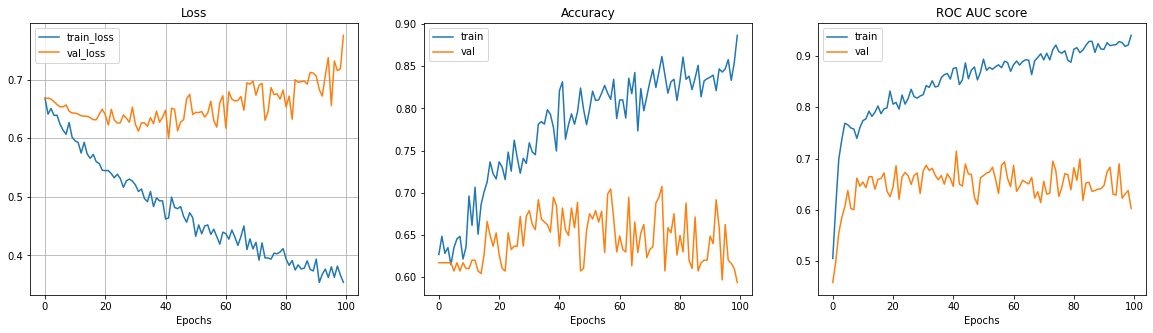

In [721]:
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.title('Loss')
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.grid(which='both')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(132)
plt.title('Accuracy')
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(133)
plt.title('ROC AUC score')
plt.plot(train_roc_aucs, label='train')
plt.plot(val_roc_aucs, label='val')
plt.xlabel('Epochs')
plt.legend()

plt.show()

## 5-fold cross validation

In [ ]:
# /!\ we perform splits at the patient level so that all samples from the same patient
# are found in the same split

patients_unique = np.unique(patients_train)
y_unique = np.array(
    [np.mean(y_train[patients_train == p]) for p in patients_unique]
)
centers_unique = np.array(
    [centers_train[patients_train == p][0] for p in patients_unique]
)

print(
    "Training set specifications\n"
    "---------------------------\n"
    f"{len(X_train)} unique samples\n"
    f"{len(patients_unique)} unique patients\n"
    f"{len(np.unique(centers_unique))} unique centers"
)

Training set specifications
---------------------------
344 unique samples
305 unique patients
3 unique centers


In [ ]:
K = 5 # num k-fold

In [ ]:
aucs = []
lrs = []
# K-fold CV is repeated K times with different random states
for k in range(K):
    kfold = StratifiedKFold(K, shuffle=True, random_state=k)
    fold = 0
    # split is performed at the patient-level
    for train_idx_, val_idx_ in kfold.split(patients_unique, y_unique):
        # retrieve the indexes of the samples corresponding to the
        # patients in `train_idx_` and `test_idx_`
        train_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[train_idx_])
        ]
        val_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[val_idx_])
        ]
        # set the training and validation folds
        X_fold_train = X_train[train_idx]
        y_fold_train = y_train[train_idx]
        X_fold_val = X_train[val_idx]
        y_fold_val = y_train[val_idx]
        # instantiate the model
        lr = LogisticRegression(C=0.01, solver="liblinear")
        # lr = SVC(C=0.01, probability=True)
        # fit it
        lr.fit(X_fold_train, y_fold_train)
        # get the predictions (1-d probability)
        preds_val = lr.predict_proba(X_fold_val)[:, 1]
        # compute the AUC score using scikit-learn
        auc = roc_auc_score(y_fold_val, preds_val)
        print(f"AUC on split {k} fold {fold}: {auc:.3f}")
        aucs.append(auc)
        # add the logistic regression to the list of classifiers
        lrs.append(lr)
        fold += 1
    print("----------------------------")
print(
    f"5-fold cross-validated AUC averaged over {k+1} repeats: "
    f"{np.mean(aucs):.3f} ({np.std(aucs):.3f})"
)

AUC on split 0 fold 0: 0.590
AUC on split 0 fold 1: 0.490
AUC on split 0 fold 2: 0.673
AUC on split 0 fold 3: 0.705
AUC on split 0 fold 4: 0.536
----------------------------
AUC on split 1 fold 0: 0.695
AUC on split 1 fold 1: 0.667
AUC on split 1 fold 2: 0.498
AUC on split 1 fold 3: 0.502
AUC on split 1 fold 4: 0.558
----------------------------
AUC on split 2 fold 0: 0.568
AUC on split 2 fold 1: 0.730
AUC on split 2 fold 2: 0.593
AUC on split 2 fold 3: 0.524
AUC on split 2 fold 4: 0.517
----------------------------
AUC on split 3 fold 0: 0.718
AUC on split 3 fold 1: 0.661
AUC on split 3 fold 2: 0.535
AUC on split 3 fold 3: 0.471
AUC on split 3 fold 4: 0.447
----------------------------
AUC on split 4 fold 0: 0.563
AUC on split 4 fold 1: 0.535
AUC on split 4 fold 2: 0.697
AUC on split 4 fold 3: 0.455
AUC on split 4 fold 4: 0.607
----------------------------
5-fold cross-validated AUC averaged over 5 repeats: 0.581 (0.087)


# Submission

Now we evaluate the previous models trained through cross-validation so that to produce a submission file that can directly be uploaded on the data challenge platform.

## Data processing

In [436]:
X_test = []

# load the data from `df_test` (~ 1 minute)
for sample in tqdm(df_test["Sample ID"].values):
    _features = np.load(test_features_dir / sample)
    coordinates, features = _features[:, :3], _features[:, 3:]
    X_test.append(np.mean(features, axis=0))

X_test = np.array(X_test)

100%|██████████| 149/149 [00:08<00:00, 18.27it/s]


## Inference

In [ ]:
preds_test = 0
# loop over the classifiers
for lr in lrs:
    preds_test += lr.predict_proba(X_test)[:, 1]
# and take the average (ensembling technique)
preds_test = preds_test / len(lrs)

## Saving predictions

In [ ]:
submission = pd.DataFrame(
    {"Sample ID": df_test["Sample ID"].values, "Target": preds_test}
).sort_values(
    "Sample ID"
)  # extra step to sort the sample IDs

# sanity checks
assert all(submission["Target"].between(0, 1)), "`Target` values must be in [0, 1]"
assert submission.shape == (149, 2), "Your submission file must be of shape (149, 2)"
assert list(submission.columns) == [
    "Sample ID",
    "Target",
], "Your submission file must have columns `Sample ID` and `Target`"

# save the submission as a csv file
submission.to_csv(data_dir / "svc2_test_output.csv", index=None)
submission.head()

,Sample ID,Target
0,ID_003.npy,0.510347
1,ID_004.npy,0.392907
2,ID_008.npy,0.401032
3,ID_009.npy,0.408939
4,ID_010.npy,0.313124


# Dealing with images

The following code aims to load and manipulate the images provided as part of  this challenge.

## Scanning images paths on disk

This operation can take up to 5 minutes.

In [ ]:
train_images_dir = data_dir / "train_input" / "images"
train_images_files = list(train_images_dir.rglob("*.jpg"))

test_images_dir = data_dir / "test_input" / "images"
test_images_files = list(test_images_dir.rglob("*.jpg"))

print(
    f"Number of images\n"
    "-----------------\n"
    f"Train: {len(train_images_files)}\n" # 344 x 1000 = 344,000 tiles
    f"Test: {len(test_images_files)}\n"  # 149 x 1000 = 149,000 tiles
    f"Total: {len(train_images_files) + len(test_images_files)}\n"  # 493 x 1000 = 493,000 tiles
)

Number of images
-----------------
Train: 344000
Test: 149000
Total: 493000



## Reading

Now we can load some of the `.jpg` images for a given sample, say `ID_001`.

In [ ]:
ID_001_tiles = [p for p in train_images_files if 'ID_001' in p.name]

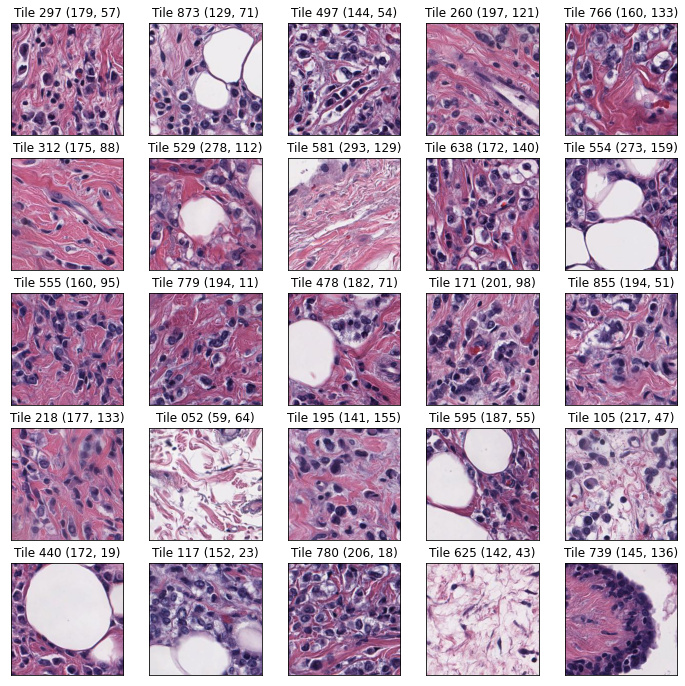

In [ ]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(12, 12)

for i, img_file in enumerate(ID_001_tiles[:25]):
    # get the metadata from the file path
    _, metadata = str(img_file).split("tile_")
    id_tile, level, x, y = metadata[:-4].split("_")
    img = plt.imread(img_file)
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Tile {id_tile} ({x}, {y})")
plt.show()

## Mapping with features

Note that the coordinates in the features matrices and tiles number are aligned.

In [ ]:
sample = "ID_001.npy"
_features = np.load(train_features_dir / sample)
coordinates, features = _features[:, :3], _features[:, 3:]
print("xy features coordinates")
coordinates[:10, 1:].astype(int)

xy features coordinates


array([[170,  43],
       [245,  49],
       [137, 128],
       [218,  40],
       [142, 117],
       [129,  72],
       [129,  88],
       [164, 109],
       [210,  39],
       [222, 100]])

In [ ]:
print(
    "Tiles numbering and features coordinates\n"
)
[tile.name for tile in ID_001_tiles[:10]]

Tiles numbering and features coordinates



['ID_001_tile_297_17_179_57.jpg',
 'ID_001_tile_873_17_129_71.jpg',
 'ID_001_tile_497_17_144_54.jpg',
 'ID_001_tile_260_17_197_121.jpg',
 'ID_001_tile_766_17_160_133.jpg',
 'ID_001_tile_312_17_175_88.jpg',
 'ID_001_tile_529_17_278_112.jpg',
 'ID_001_tile_581_17_293_129.jpg',
 'ID_001_tile_638_17_172_140.jpg',
 'ID_001_tile_554_17_273_159.jpg']